In [8]:
import numpy
import pandas

# Define the Elastic Net model
class ElasticNetModel:
    def __init__(self, lamda=1.0, l1_ratio=0.5, max_iter=1000, tol=1e-4):
        self.lamda = lamda
        self.l1_ratio = l1_ratio
        self.max_iter = max_iter
        self.tol = tol
        self.coef_ = None
        self.intercept_ = 0
        self.mean_X = None
        self.std_X = None
        self.mean_y = None
        self.std_y = None

    def fit(self, X, y):
        self.mean_X = numpy.mean(X, axis=0)
        self.std_X = numpy.std(X, axis=0)
        X_normalized = (X - self.mean_X) / self.std_X

        self.mean_y = numpy.mean(y)
        self.std_y = numpy.std(y)
        y_normalized = (y - self.mean_y) / self.std_y

        X_bias = numpy.c_[numpy.ones(X_normalized.shape[0]), X_normalized]

        # Initialize coefficients
        n_samples, n_features = X_bias.shape
        self.coef_ = numpy.zeros(n_features)

        # Define penalties
        l1_penalty = self.lamda * self.l1_ratio
        l2_penalty = self.lamda * (1 - self.l1_ratio)

        # Descent algorithm
        for iteration in range(self.max_iter):
            coef_old = self.coef_.copy()

            for j in range(n_features):
                residual = y_normalized - X_bias @ self.coef_
                rho = X_bias[:, j].T @ (residual + X_bias[:, j] * self.coef_[j])

                if j == 0:
                    self.coef_[j] = rho / X_bias[:, j].T @ X_bias[:, j]
                else:
                    self.coef_[j] = self._soft_threshold(rho, l1_penalty) / (X_bias[:, j].T @ X_bias[:, j] + l2_penalty)

            if numpy.sum(numpy.abs(self.coef_ - coef_old)) < self.tol:
                break

        self.intercept_ = self.coef_[0]
        self.coef_ = self.coef_[1:]

        return ElasticNetModelResults(self.intercept_, self.coef_, self.mean_X, self.std_X, self.mean_y, self.std_y)

    def _soft_threshold(self, rho, lambda_):
        if rho < -lambda_:
            return rho + lambda_
        elif rho > lambda_:
            return rho - lambda_
        else:
            return 0

class ElasticNetModelResults:
    def __init__(self, intercept, coef, mean_X, std_X, mean_y, std_y):
        self.intercept = intercept
        self.coef = coef
        self.mean_X = mean_X
        self.std_X = std_X
        self.mean_y = mean_y
        self.std_y = std_y

    def predict(self, X):
        # Normalize the input features
        X_normalized = (X - self.mean_X) / self.std_X
        predictions_scaled = X_normalized @ self.coef + self.intercept
        return predictions_scaled * self.std_y + self.mean_y

# Load the dataset and set the path correclty
file_path = 'winedata.csv'  
wine_data = pandas.read_csv(file_path, delimiter=';')

# Set Features and Target Variables
X = wine_data.drop(columns=['quality']).values
y = wine_data['quality'].values

# Manual train-test split
numpy.random.seed(42)  # For reproducibility
indices = numpy.arange(X.shape[0])
numpy.random.shuffle(indices)  # Shuffle the indices

# Use 80% for training and 20% for testing
train_size = int(0.8 * len(indices))
train_indices = indices[:train_size]
test_indices = indices[train_size:]

X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

# Initialize and train the Elastic Net model
elastic_net_model = ElasticNetModel(lamda=1.0, l1_ratio=0.5, max_iter=1000, tol=1e-4)
model_results = elastic_net_model.fit(X_train, y_train)

# Predict on the test set
predictions = model_results.predict(X_test)

# Mean Squared error MSE
mse = numpy.mean((y_test - predictions) ** 2)  # Manual MSE calculation

# Mean Absolte error MAE
mae = numpy.mean(numpy.abs(y_test - predictions))  # Manual MAE calculation

#  R² Value
ss = numpy.sum((y_test - numpy.mean(y_test)) ** 2)  # sum of squares
rss = numpy.sum((y_test - predictions) ** 2)      # residual sum of squares
r2 = 1 - (rss / ss)

# Display results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Manually calculated R-squared (R²): {r2}")

# Display the first few predictions
print("Predictions on the test set: ", predictions[:5])


Mean Squared Error (MSE): 0.5937068492895137
Mean Absolute Error (MAE): 0.5953604055281434
Manually calculated R-squared (R²): 0.25819373993194783
Predictions on the test set:  [5.95188846 5.69200554 6.20010439 6.02100504 5.74714876]


In [9]:
'''
We are defining this function to tabulate the results for various lambda values and l1 ratio 
and observe the behaviour of the model.
The results are tabulated
'''

def evaluate_elasticnet(lamda_values, l1_ratios, X_train, y_train, X_test, y_test):
    results = []
    # Loop to iterate through all values of lambda and l1 ratio
    for lamda in lamda_values:
        for l1_ratio in l1_ratios:
            elastic_net_model = ElasticNetModel(lamda=lamda, l1_ratio=l1_ratio, max_iter=1000, tol=1e-4)
            model_results = elastic_net_model.fit(X_train, y_train)

            predictions = model_results.predict(X_test)

            # Calculation for MSE, MAE, and R²
            mse = numpy.mean((y_test - predictions) ** 2) 
            mae = numpy.mean(numpy.abs(y_test - predictions))
            sst = numpy.sum((y_test - numpy.mean(y_test)) ** 2)
            ssr = numpy.sum((y_test - predictions) ** 2)
            r2 = 1 - (ssr / sst)                     

            results.append([lamda, l1_ratio, mse, mae, r2])

    return pandas.DataFrame(results, columns=['Lambda', 'L1 Ratio', 'MSE', 'MAE', 'R2'])

# Set different lambda and l1_ratio values
lamda_values = [0.1, 1.0, 100, 10000]
l1_ratios = [0.1, 0.5, 0.9]

results_df = evaluate_elasticnet(lamda_values, l1_ratios, X_train, y_train, X_test, y_test)
results_df



,Lambda,L1 Ratio,MSE,MAE,R2
0,0.1,0.1,0.593711,0.595382,0.258188
1,0.1,0.5,0.593711,0.595382,0.258188
2,0.1,0.9,0.593711,0.595383,0.258189
3,1.0,0.1,0.593708,0.595359,0.258192
4,1.0,0.5,0.593707,0.595360,0.258194
5,1.0,0.9,0.593706,0.595362,0.258194
6,100.0,0.1,0.594609,0.594974,0.257066
7,100.0,0.5,0.596239,0.596467,0.255030
8,100.0,0.9,0.600183,0.599217,0.250102
9,10000.0,0.1,0.765754,0.652227,0.043230


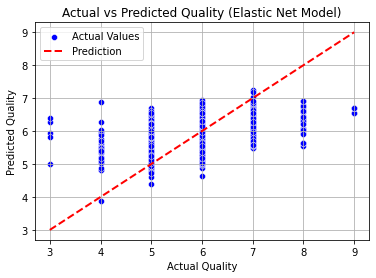

In [10]:
'''
We are using matplotlib and sns to show the plots, since it has nothing to do with the implementation of the model,
we are proceeding with the default libraries.
'''

import matplotlib.pyplot as plt
import seaborn as sns

# Visualize Actual vs Predicted for Elastic Net Model
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test, y=predictions, color='blue', label='Actual Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Prediction')
plt.title('Actual vs Predicted Quality (Elastic Net Model)')
plt.xlabel('Actual Quality')
plt.ylabel('Predicted Quality')
plt.legend()
plt.grid(True)
plt.show()